# **Bin packing problem**

***bin_packing.ipynb***

Pack $n$ items into $m$ bins minimizing the number of bins used. Showcases the use of the `xp.Dot` operator.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

## Problem description and formulation



There are $n$ items, each with a positive integer size $s_i, \forall i \in \mathcal{I}$, and $m$ bins, each with capacity $c_b, \forall b \in \mathcal{B}$. Our goal is to pack every item into a bin so as to **minimize** the total number of bins in use. 

We introduce two families of binary variables:

$$
x_{b,i} =
\begin{cases}
1, & \text{if item }i\text{ is placed into bin }b,\\
0, & \text{otherwise},
\end{cases}
$$
$$
y_b =
\begin{cases}
1, & \text{if bin }b\text{ is used},\\
0, & \text{otherwise}.
\end{cases}
$$

- $x_{b,i}$ ensures each item is assigned to exactly one bin.  
- $y_b$ allows us to count how many bins are actually used.

The objective is to minimize the total number of bins used:

$$
\min \sum_{b \in \mathcal{B}} y_b.
$$

Subject to the following constraints:

* Each item must go into exactly one bin:
   $$
   \sum_{b \in \mathcal{B}} x_{b,i} = 1,
   \quad \forall i \in \mathcal{I}.
   $$

* Bin capacity linking:
   $$
   \sum_{i \in \mathcal{I}} s_i\,x_{b,i}
   \le C_b\,y_b,
   \quad \forall b \in \mathcal{B}.
   $$



## Data preparation

In this step, all the necessary packages are imported, the scalar parameters and ranges for data generation are defined. Then, item sizes and bin capacities are generated as `NumPy` arrays using `np.random.randint()` within the pre-defined ranges.

In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
NITEMS = 20         # Number of items
NBINS = 11          # Number of bins
MinSize = 20        # Minimum size of an item
MaxSize = 39        # Maximum size of an item
MinCapacity = 40    # Minimum capacity of a bin
MaxCapacity = 89    # Maximum capacity of a bin

# Random data generation for item sizes and bin capacities
np.random.seed(2)
sizes = np.random.randint(MinSize, MaxSize + 1, size=NITEMS)
capacities = np.random.randint(MinCapacity, MaxCapacity + 1, size=NBINS)
total_size = sizes.sum()

## Model implementation

We create an Xpress problem named **Binpacking** and define two sets of binary variables (`contains` and `binused`$) by calling[`p.addVariables()`](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html). When passing integer arguments to [p.addVariables()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), a *NumPy* arrays of variables is created.

The objective function is created and added to the problem by passing the summation over the array of variables `binused` to [`p.setObjective()`](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.setObjective.html). The optimization sense is to minimize the function, by default.

Similarly, constraints are created and added to the problem by passing the corresponding expressions using list comprehension to [`p.addConstraint()`](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addConstraint.html). 

The set of capacity constraints leverages the use of the [`xp.Dot()`](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/xpress.Dot.html) operator to perform the  dot‑product between the `contains` variable matrix and the `sizes` array, generating `NBINS` constraints at once with a compact and more efficient expression. The right-hand-sides of those each constraints are mapped to the  array resulting from the multiplication between the `capacity` and the `binused` arrays.

After building the model, we turn off solver logging using the `OUTPUTLOG` control and call [`p.optimize()`](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.optimize.html) to solve the problem, then extract the solutions and print both the number of bins used and the detailed item‑to‑bin assignments.

In [ ]:
p = xp.problem(name="Binpacking")

# Decision variables:
# Binary variables equal to 1 iff item i is placed in bin b, and 0 otherwise
contains = p.addVariables(NBINS, NITEMS, vartype=xp.binary, name="c")
# Binary variables equal to 1 iff bin b is used, and 0 otherwise
binused  = p.addVariables(NBINS, vartype=xp.binary, name="u")

# Objective function: minimize number of bins used
p.setObjective(xp.Sum(binused), sense=xp.minimize)

# Constraint 1: each item in exactly one bin
p.addConstraint(xp.Sum(contains[b, i] for b in range(NBINS)) == 1 for i in range(NITEMS))

# Constraint 2: Capacity constraints
p.addConstraint(xp.Dot(contains, sizes) <= capacities * binused)

# Solve the problem
p.controls.outputlog = 0  # Turn off solver logging for cleaner output
p.optimize()

ct = p.getSolution(contains)
used = p.getSolution(binused)

# Print results
print("Total number of bins used:", used.sum())
for b in range(NBINS):
    if used[b]:
        items = [i+1 for i in range(NITEMS) if ct[b, i] == 1]
        sizes_str = " ".join(f"{i}({sizes[i-1]})" for i in items)
        print(f"Bin {b+1} (cap {capacities[b]}): items {sizes_str}")

Total number of bins used: 9.0
Bin 1 (cap 79): items 4(28) 10(22) 15(27)
Bin 2 (cap 78): items 16(23) 18(24) 19(30)
Bin 3 (cap 82): items 12(31) 14(25) 17(26)
Bin 4 (cap 73): items 2(35) 7(31)
Bin 5 (cap 43): items 6(38)
Bin 7 (cap 64): items 3(33) 20(31)
Bin 8 (cap 44): items 11(37)
Bin 9 (cap 86): items 1(28) 8(28) 9(27)
Bin 11 (cap 71): items 5(31) 13(35)


## Visualization

The code below allows to visualize each bin used with a stacked bar formed by the sizes of the items assigned to it, and a dashed line marking the bin capacity.

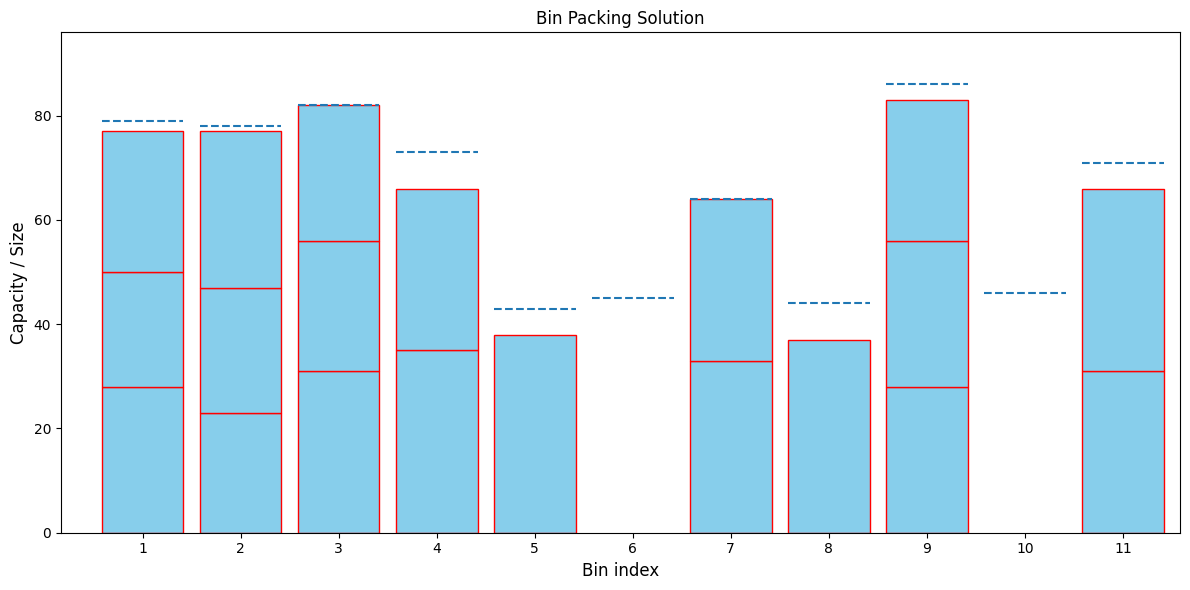

In [4]:
# Visualization:
fig, ax = plt.subplots(figsize=(12, 6))
for b in range(NBINS):
    y_offset = 0
    for i in range(NITEMS):
        if ct[b, i]:
            rect = plt.Rectangle((b*1.2, y_offset), 1, sizes[i], edgecolor='red', facecolor='skyblue')
            ax.add_patch(rect)
            y_offset += sizes[i]
    ax.hlines(capacities[b], b*1.2, b*1.2 + 1, linestyle='dashed')

ax.set_xlim(-0.5, NBINS*1.2)
ax.set_ylim(0, capacities.max() + 10)
ax.set_xlabel('Bin index', fontsize=12)
ax.set_ylabel('Capacity / Size', fontsize=12)
ax.set_title('Bin Packing Solution')
ax.set_xticks([b*1.2 + 0.5 for b in range(NBINS)])
ax.set_xticklabels([str(b+1) for b in range(NBINS)])
plt.tight_layout()
plt.show()
